<a href="https://colab.research.google.com/github/jsansao/teic-20231/blob/main/TEIC_Licao11_TransferLearningKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lição 11 - Transfer Learning

Nesta tarefa, vamos comparar diferentes estruturas no reconhecimento de gestos de uma partida de pedra, papel e tesoura. 

Utilizaremos redes pré-treinadas com a base imagenet e faremos o aprendizado por transferência. Neste tipo de treinamento, fixamos parte dos coeficientes da rede e adicionamos um novo classificador específico para a tarefa. 

Vamos comparar as seguintes redes disponibilizadas pelo TensorFlow/Keras: 



1. InceptionV3
2. VGG16
3. Xception
4. DenseNet

Para cada uma, você deverá determinar os melhores valores de acurácia (treinamento e validação), número de parâmetros treináveis e não treináveis (Ver o model.summary())







## Carregamento do banco de imagens

Os conjuntos estão divididos em dois arquivos zipados. O primeiro é o conjunto de treinamento, o segundo é o conjunto de validação. 

Em cada arquivo zipado, temos três diretórios, correspondentes a imagens de pedra, papel e tesoura. Com o ImageGenerator, vamos gerar os tensores para serem processados. 



In [1]:
!wget --no-check-certificate https://github.com/jsansao/rps/archive/refs/heads/main.zip 

--2023-05-17 20:57:01--  https://github.com/jsansao/rps/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jsansao/rps/zip/refs/heads/main [following]
--2023-05-17 20:57:01--  https://codeload.github.com/jsansao/rps/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 219.58M  30.0MB/s    in 7.6s    

2023-05-17 20:57:09 (29.0 MB/s) - ‘main.zip’ saved [230245117]



In [3]:
!unzip main.zip

Archive:  main.zip
2ab904a375abc266ab8ee31b5b8f06c256d01c2c
   creating: rps-main/
 extracting: rps-main/README.md      
   creating: rps-main/rps-test-set/
   creating: rps-main/rps-test-set/paper/
 extracting: rps-main/rps-test-set/paper/testpaper01-00.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-01.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-02.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-03.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-04.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-05.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-06.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-07.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-08.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-09.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-10.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-11.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-12.p

## 1. InceptionV3

In [4]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
  
from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = "imagenet")



for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

87910968/87910968 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 32s - loss: 3.3771 - accuracy: 0.8165 - val_loss: 0.8503 - val_accuracy: 0.7200 - 32s/epoch - 315ms/step
Epoch 2/20
100/100 - 17s - loss: 0.5576 - accuracy: 0.9150 - val_loss: 0.2835 - val_accuracy: 0.9250 - 17s/epoch - 167ms/step
Epoch 3/20
100/100 - 17s - loss: 0.3053 - accuracy: 0.9425 - val_loss: 0.2730 - val_accuracy: 0.9150 - 17s/epoch - 171ms/step
Epoch 4/20
100/100 - 17s - loss: 0.2410 - accuracy: 0.9545 - val_loss: 0.3722 - val_accuracy: 0.8500 - 17s/epoch - 165ms/step
Epoch 5/20
100/100 - 18s - loss: 0.1692 - accuracy: 0.9600 - val_loss: 0.2190 - val_accuracy: 0.9350 - 18s/epoch - 179ms/step
Epoch 6/20
100/100 - 17s - loss: 0.2109 - accuracy: 0.9605 - val_loss: 1.1203 - val_accuracy: 0.7100 - 17s/epoch - 165ms/step
Epoch 7/20
100/100 - 16s - loss: 0.1726 - accuracy: 0.9640 - val_loss: 0.3478 - val_accuracy: 0.8850 - 16s/epoch - 164ms/step
Epoch 8/20
100/100 - 17s - loss: 0.1537 - accuracy: 0.9650 - val_loss: 0.9363 - val_accuracy: 0.8100 - 17s/epoch - 166

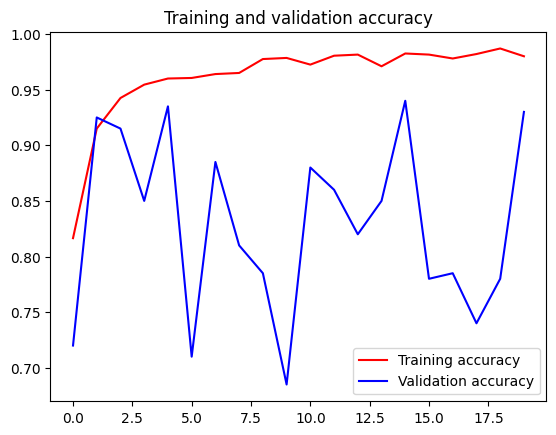

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 2. VGG16

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np



pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

In [11]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [13]:
train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [14]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 19s - loss: 0.4930 - accuracy: 0.8325 - val_loss: 0.1250 - val_accuracy: 0.9300 - 19s/epoch - 194ms/step
Epoch 2/20
100/100 - 17s - loss: 0.1257 - accuracy: 0.9560 - val_loss: 0.3357 - val_accuracy: 0.8300 - 17s/epoch - 174ms/step
Epoch 3/20
100/100 - 17s - loss: 0.0799 - accuracy: 0.9715 - val_loss: 0.3294 - val_accuracy: 0.8550 - 17s/epoch - 166ms/step
Epoch 4/20
100/100 - 16s - loss: 0.0740 - accuracy: 0.9785 - val_loss: 0.7754 - val_accuracy: 0.8300 - 16s/epoch - 164ms/step
Epoch 5/20
100/100 - 17s - loss: 0.0689 - accuracy: 0.9760 - val_loss: 0.0082 - val_accuracy: 1.0000 - 17s/epoch - 167ms/step
Epoch 6/20
100/100 - 17s - loss: 0.0499 - accuracy: 0.9810 - val_loss: 0.0017 - val_accuracy: 1.0000 - 17s/epoch - 168ms/step
Epoch 7/20
100/100 - 18s - loss: 0.0502 - accuracy: 0.9840 - val_loss: 0.6203 - val_accuracy: 0.8050 - 18s/epoch - 184ms/step
Epoch 8/20
100/100 - 16s - loss: 0.0469 - accuracy: 0.9880 - val_loss: 0.2882 - val_accuracy: 0.8650 - 16s/epoch - 163

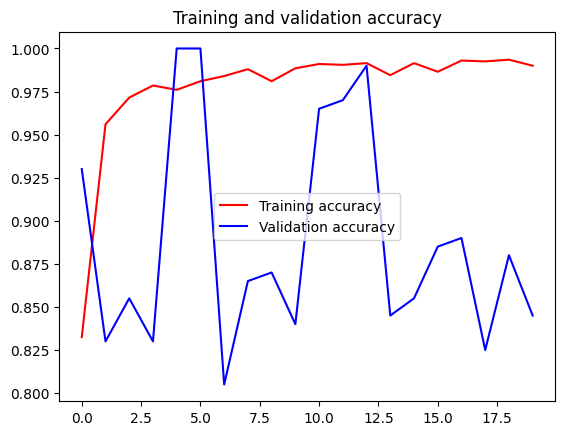

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 3. Xception

In [16]:
import tensorflow.keras.applications.xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

pre_trained_model = Xception(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


83683744/83683744 [==============================] - 0s 0us/step


In [17]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [19]:

train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [20]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 23s - loss: 2.4856 - accuracy: 0.7690 - val_loss: 1.3054 - val_accuracy: 0.6300 - 23s/epoch - 230ms/step
Epoch 2/20
100/100 - 17s - loss: 0.3938 - accuracy: 0.8930 - val_loss: 0.4551 - val_accuracy: 0.8550 - 17s/epoch - 173ms/step
Epoch 3/20
100/100 - 17s - loss: 0.2524 - accuracy: 0.9145 - val_loss: 0.5400 - val_accuracy: 0.8350 - 17s/epoch - 166ms/step
Epoch 4/20
100/100 - 18s - loss: 0.1641 - accuracy: 0.9440 - val_loss: 0.2579 - val_accuracy: 0.9150 - 18s/epoch - 182ms/step
Epoch 5/20
100/100 - 17s - loss: 0.1739 - accuracy: 0.9490 - val_loss: 0.2931 - val_accuracy: 0.8950 - 17s/epoch - 173ms/step
Epoch 6/20
100/100 - 16s - loss: 0.1237 - accuracy: 0.9625 - val_loss: 0.3482 - val_accuracy: 0.8950 - 16s/epoch - 161ms/step
Epoch 7/20
100/100 - 17s - loss: 0.1445 - accuracy: 0.9570 - val_loss: 0.2544 - val_accuracy: 0.9350 - 17s/epoch - 173ms/step
Epoch 8/20
100/100 - 16s - loss: 0.1212 - accuracy: 0.9640 - val_loss: 0.1991 - val_accuracy: 0.9300 - 16s/epoch - 161

## 4. DenseNet

In [21]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

pre_trained_model = DenseNet201(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


74836368/74836368 [==============================] - 0s 0us/step


In [22]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [23]:
train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [24]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 34s - loss: 1.7898 - accuracy: 0.8460 - val_loss: 0.4347 - val_accuracy: 0.9100 - 34s/epoch - 336ms/step
Epoch 2/20
100/100 - 18s - loss: 0.3001 - accuracy: 0.9460 - val_loss: 2.3808 - val_accuracy: 0.7000 - 18s/epoch - 182ms/step
Epoch 3/20
100/100 - 17s - loss: 0.1629 - accuracy: 0.9640 - val_loss: 1.2525 - val_accuracy: 0.7850 - 17s/epoch - 174ms/step
Epoch 4/20
100/100 - 19s - loss: 0.1573 - accuracy: 0.9720 - val_loss: 1.8883 - val_accuracy: 0.7900 - 19s/epoch - 195ms/step
Epoch 5/20
100/100 - 18s - loss: 0.1071 - accuracy: 0.9800 - val_loss: 0.9459 - val_accuracy: 0.8950 - 18s/epoch - 177ms/step
Epoch 6/20
100/100 - 18s - loss: 0.0511 - accuracy: 0.9895 - val_loss: 0.9280 - val_accuracy: 0.8650 - 18s/epoch - 185ms/step
Epoch 7/20
100/100 - 17s - loss: 0.1203 - accuracy: 0.9815 - val_loss: 3.9872 - val_accuracy: 0.7150 - 17s/epoch - 171ms/step
Epoch 8/20
100/100 - 17s - loss: 0.0572 - accuracy: 0.9890 - val_loss: 3.0041 - val_accuracy: 0.7900 - 17s/epoch - 169